In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
import tkinter as tk
from tkinter import messagebox
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string

# Ensure matplotlib plots are displayed inline in Jupyter
%matplotlib inline

In [2]:
# Loading and preprocessing the dataset
print("Loading dataset...")
data = pd.read_csv("stress (1).csv")

# Selecting relevant features: text and numerical LIWC features, label as target
text_feature = "text"
label = "label"
liwc_features = [col for col in data.columns if col.startswith("lex_liwc_")]

# Handling missing values
print("Removing rows with NaN in selected features...")
data = data.dropna(subset=[text_feature, label] + liwc_features)

# Augment the dataset with additional stress-related samples
augmented_samples = pd.DataFrame(
    {
        "text": [
            "I was beaten badly by someone",
            "I was abused and threatened",
            "I got attacked on my way home",
            "Someone assaulted me yesterday",
            "I was beaten and left injured",
            "I feel abused and scared after the incident",
        ],
        "label": [1, 1, 1, 1, 1, 1],
    }
)
data = pd.concat([data, augmented_samples], ignore_index=True)

# Check class distribution
print("Class distribution:")
print(data[label].value_counts())

# Clean dataset: Relabel 'grief' and 'sadness' samples as 'Stress' (1) unless they contain 'overcome'
print("Relabeling 'grief' and 'sadness' samples...")
mask_grief = data["text"].str.contains("grief", case=False, na=False)
mask_sadness = data["text"].str.contains("sadness", case=False, na=False)
mask_overcome = data["text"].str.contains("overcome", case=False, na=False)
data.loc[(mask_grief | mask_sadness) & ~mask_overcome, "label"] = 1

# Relabel stress-related samples ('beaten', 'assaulted', 'attacked', 'abused') as 'Stress' (1)
print("Relabeling stress-related samples...")
mask_beaten = data["text"].str.contains("beaten", case=False, na=False)
mask_assaulted = data["text"].str.contains("assaulted", case=False, na=False)
mask_attacked = data["text"].str.contains("attacked", case=False, na=False)
mask_abused = data["text"].str.contains("abused", case=False, na=False)
data.loc[mask_beaten | mask_assaulted | mask_attacked | mask_abused, "label"] = 1

# Relabel positive sentiment samples as 'No Stress' (0) unless they contain stress indicators
print("Relabeling positive sentiment samples...")
mask_happy = data["text"].str.contains("happ", case=False, na=False)  # covers 'happy', 'happiness'
mask_joy = data["text"].str.contains("joy", case=False, na=False)
mask_stress = data["text"].str.contains(
    "stress|anxiety|depress|sad|grief|beaten|assault|attack|abused", case=False, na=False
)
data.loc[(mask_happy | mask_joy) & ~mask_stress, "label"] = 0

# Check class distribution after relabeling
print("\nClass distribution after relabeling:")
print(data[label].value_counts())

Loading dataset...
Removing rows with NaN in selected features...
Class distribution:
label
1    1494
0    1350
Name: count, dtype: int64
Relabeling 'grief' and 'sadness' samples...
Relabeling stress-related samples...
Relabeling positive sentiment samples...

Class distribution after relabeling:
label
0    1483
1    1361
Name: count, dtype: int64


In [3]:
# Combining text and LIWC features
X_text = data[text_feature]
X_numerical = data[liwc_features]
y = data[label]

# Text vectorization using TF-IDF
print("Fitting TF-IDF vectorizer...")
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 3), lowercase=True, max_features=15000)
X_text_tfidf = tfidf.fit_transform(X_text)
X_text_tfidf_dense = X_text_tfidf.toarray()

# Check for NaN in TF-IDF features
if np.isnan(X_text_tfidf_dense).any():
    print("Warning: NaN values found in TF-IDF features. Imputing with 0...")
    X_text_tfidf_dense = np.nan_to_num(X_text_tfidf_dense, nan=0.0)

# Scaling numerical features to [0, 1] for MultinomialNB
print("Scaling numerical features...")
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_numerical_imputed = imputer.fit_transform(X_numerical)
scaler = MinMaxScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical_imputed)

# Check for NaN in scaled numerical features
if np.isnan(X_numerical_scaled).any():
    print("Warning: NaN values found in scaled numerical features. Imputing with 0...")
    X_numerical_scaled = np.nan_to_num(X_numerical_scaled, nan=0.0)

# Combining text and numerical features for the main model
print("Combining features for main model...")
X = np.hstack((X_text_tfidf_dense, X_numerical_scaled))

# Check for NaN in combined features
if np.isnan(X).any():
    print("Error: NaN values found in combined feature matrix. Imputing with 0...")
    X = np.nan_to_num(X, nan=0.0)

# Feature selection with SelectKBest
print("Selecting top features...")
selector = SelectKBest(chi2, k=5000)
X_reduced = selector.fit_transform(X, y)

Fitting TF-IDF vectorizer...
Scaling numerical features...
Combining features for main model...
Selecting top features...


In [4]:
# Splitting the dataset for the main model
print("Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# Check test set distribution
print("Test set distribution (MultinomialNB):")
print(pd.Series(y_test).value_counts())

# Handling class imbalance with SMOTE
print("Applying SMOTE for class imbalance...")
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())

Splitting dataset...
Test set distribution (MultinomialNB):
label
0    297
1    272
Name: count, dtype: int64
Applying SMOTE for class imbalance...
Class distribution after SMOTE:
label
0    1186
1    1186
Name: count, dtype: int64


In [5]:
# Training the main model (Multinomial Naive Bayes with hyperparameter tuning)
print("Training main model with hyperparameter tuning...")
model = MultinomialNB()
param_grid_nb = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]}
grid_search_nb = GridSearchCV(model, param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train, y_train)
model = grid_search_nb.best_estimator_
print("Best MultinomialNB parameters:", grid_search_nb.best_params_)

# Evaluating the main model (MultinomialNB)
print("Evaluating main model (MultinomialNB)...")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="binary")

# Printing evaluation metrics for MultinomialNB
print(f"\nMain Model Performance (MultinomialNB):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print("\nClassification Report (MultinomialNB):")
print(classification_report(y_test, y_pred, target_names=["No Stress", "Stress"]))

Training main model with hyperparameter tuning...
Best MultinomialNB parameters: {'alpha': 0.01}
Evaluating main model (MultinomialNB)...

Main Model Performance (MultinomialNB):
Accuracy: 0.9420
Precision: 0.9223

Classification Report (MultinomialNB):
              precision    recall  f1-score   support

   No Stress       0.96      0.93      0.94       297
      Stress       0.92      0.96      0.94       272

    accuracy                           0.94       569
   macro avg       0.94      0.94      0.94       569
weighted avg       0.94      0.94      0.94       569



In [6]:
# Training LogisticRegression as an alternative model
print("Training LogisticRegression model...")
scaler_lr = MinMaxScaler()  # Using MinMaxScaler for compatibility with chi2
X_numerical_scaled_lr = scaler_lr.fit_transform(X_numerical_imputed)
X_lr = np.hstack((X_text_tfidf_dense, X_numerical_scaled_lr))
X_reduced_lr = selector.fit_transform(X_lr, y)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_reduced_lr, y, test_size=0.2, random_state=42, stratify=y)

# Check test set distribution
print("Test set distribution (LogisticRegression):")
print(pd.Series(y_test_lr).value_counts())

X_train_lr, y_train_lr = smote.fit_resample(X_train_lr, y_train_lr)
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_lr, y_train_lr)

# Evaluating LogisticRegression
print("Evaluating LogisticRegression model...")
y_pred_lr = model_lr.predict(X_test_lr)
accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)
precision_lr = precision_score(y_test_lr, y_pred_lr, average="binary")
print(f"\nLogisticRegression Model Performance:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print("\nClassification Report (LogisticRegression):")
print(classification_report(y_test_lr, y_pred_lr, target_names=["No Stress", "Stress"]))

Training LogisticRegression model...
Test set distribution (LogisticRegression):
label
0    297
1    272
Name: count, dtype: int64
Evaluating LogisticRegression model...

LogisticRegression Model Performance:
Accuracy: 0.7768
Precision: 0.7491

Classification Report (LogisticRegression):
              precision    recall  f1-score   support

   No Stress       0.81      0.75      0.78       297
      Stress       0.75      0.80      0.77       272

    accuracy                           0.78       569
   macro avg       0.78      0.78      0.78       569
weighted avg       0.78      0.78      0.78       569



In [7]:
# Train a separate TF-IDF-only model for GUI predictions using SVM
print("Training TF-IDF-only model with SVM...")
X_text_only = X_text_tfidf
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text_only, y, test_size=0.2, random_state=42, stratify=y
)

# Check test set distribution
print("Test set distribution (SVM):")
print(pd.Series(y_test_text).value_counts())

svm = SVC(probability=True, random_state=42, class_weight={0: 0.9, 1: 1.1})
param_grid = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_text, y_train_text)

# Best model from grid search
model_text_only = grid_search.best_estimator_
print("Best SVM parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate the TF-IDF-only model
print("Evaluating TF-IDF-only model...")
y_pred_text = model_text_only.predict(X_test_text)
accuracy_text = accuracy_score(y_test_text, y_pred_text)
precision_text = precision_score(y_test_text, y_pred_text, average="binary")
print(f"\nTF-IDF-only Model Performance (SVM):")
print(f"Accuracy: {accuracy_text:.4f}")
print(f"Precision: {precision_text:.4f}")
print("\nClassification Report (TF-IDF-only):")
print(classification_report(y_test_text, y_pred_text, target_names=["No Stress", "Stress"]))

Training TF-IDF-only model with SVM...
Test set distribution (SVM):
label
0    297
1    272
Name: count, dtype: int64
Best SVM parameters: {'C': 10, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.7252747252747253
Evaluating TF-IDF-only model...

TF-IDF-only Model Performance (SVM):
Accuracy: 0.7364
Precision: 0.7210

Classification Report (TF-IDF-only):
              precision    recall  f1-score   support

   No Stress       0.75      0.74      0.75       297
      Stress       0.72      0.73      0.73       272

    accuracy                           0.74       569
   macro avg       0.74      0.74      0.74       569
weighted avg       0.74      0.74      0.74       569



Generating visualizations...


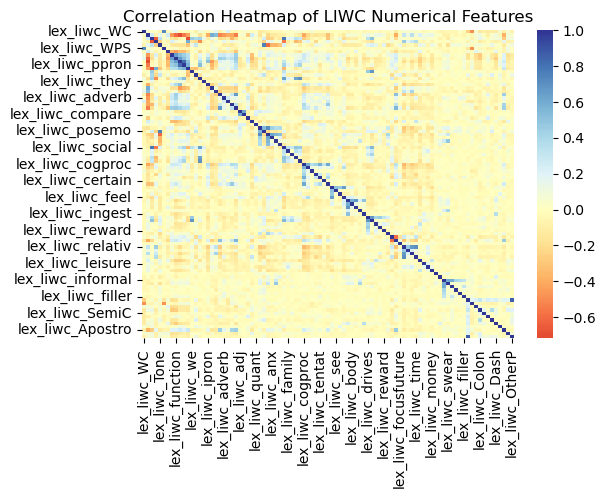

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


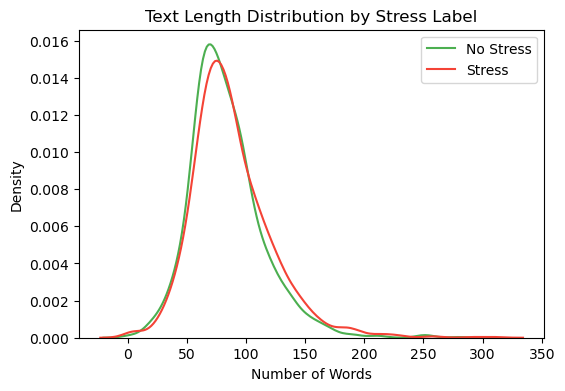

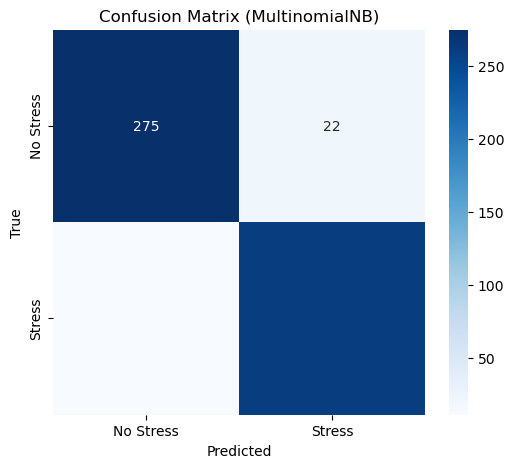

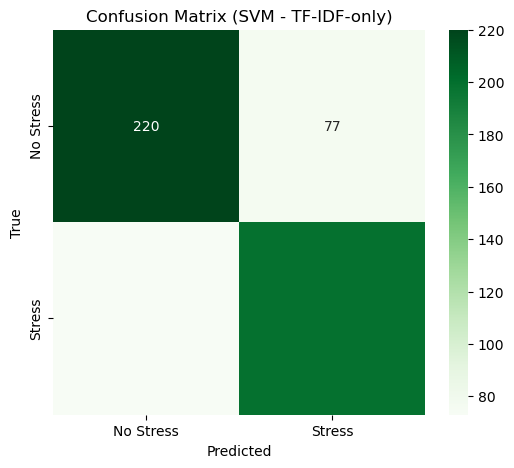

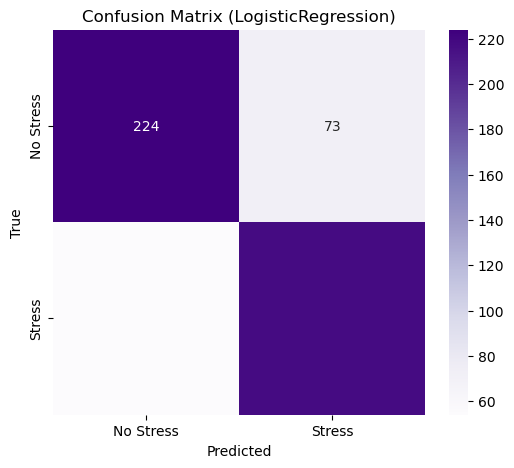

In [8]:
# Data Visualization
print("Generating visualizations...")

# 1. Heatmap: Correlation of LIWC numerical features
plt.figure(figsize=(6, 4))
sns.heatmap(X_numerical.corr(), annot=False, cmap="RdYlBu", center=0)
plt.title("Correlation Heatmap of LIWC Numerical Features")
plt.savefig("liwc_correlation_heatmap.png")
plt.show()

# 2. Line Graph: KDE of text lengths by label
data["text_length"] = data["text"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6, 4))
sns.kdeplot(data=data[data["label"] == 0], x="text_length", label="No Stress", color="#4CAF50")
sns.kdeplot(data=data[data["label"] == 1], x="text_length", label="Stress", color="#F44336")
plt.title("Text Length Distribution by Stress Label")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.legend()
plt.savefig("text_length_kde.png")
plt.show()

# 3. Confusion Matrix for MultinomialNB
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stress", "Stress"], yticklabels=["No Stress", "Stress"]
)
plt.title("Confusion Matrix (MultinomialNB)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_nb.png")
plt.show()

# 3b. Confusion Matrix for SVM (TF-IDF-only model)
cm_svm = confusion_matrix(y_test_text, y_pred_text)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_svm, 
    annot=True, 
    fmt="d", 
    cmap="Greens", 
    xticklabels=["No Stress", "Stress"], 
    yticklabels=["No Stress", "Stress"]
)
plt.title("Confusion Matrix (SVM - TF-IDF-only)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_svm.png")
plt.show()

# 3c. Confusion Matrix for LogisticRegression
cm_lr = confusion_matrix(y_test_lr, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_lr, 
    annot=True, 
    fmt="d", 
    cmap="Purples", 
    xticklabels=["No Stress", "Stress"], 
    yticklabels=["No Stress", "Stress"]
)
plt.title("Confusion Matrix (LogisticRegression)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_lr.png")
plt.show()

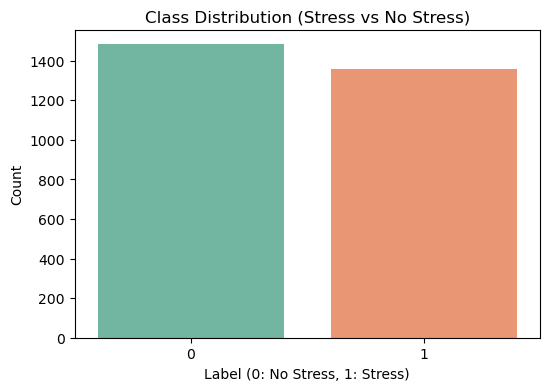


Sample Input Probabilities:
I am happy: No Stress: 0.9940, Stress: 0.0060
My day is full of happiness and joy: No Stress: 0.9225, Stress: 0.0775
I feel sad: No Stress: 0.1266, Stress: 0.8734
I am relaxed: No Stress: 0.7900, Stress: 0.2100
I was beaten by an unknown person: No Stress: 0.6486, Stress: 0.3514
I was beaten by someone: No Stress: 0.2163, Stress: 0.7837
I was beaten and abused by someone: No Stress: 0.0272, Stress: 0.9728


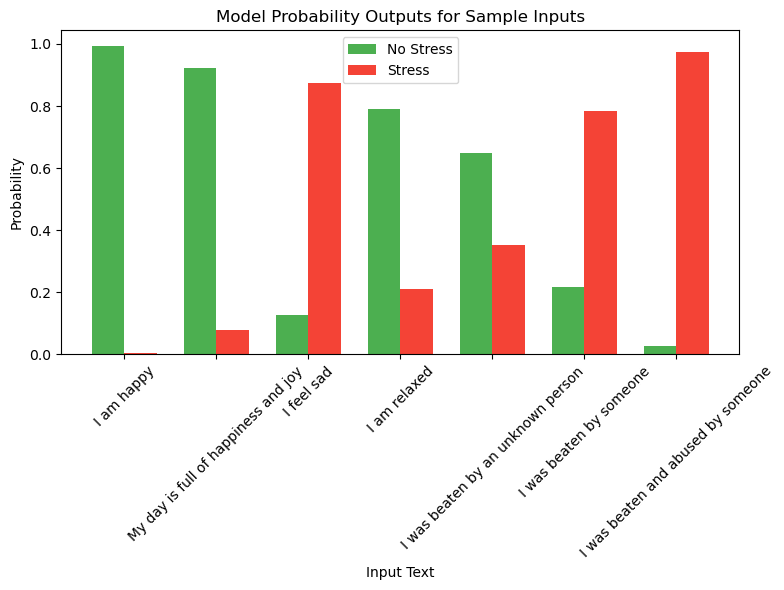

Generating word clouds...


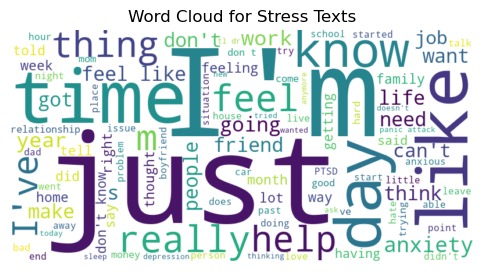

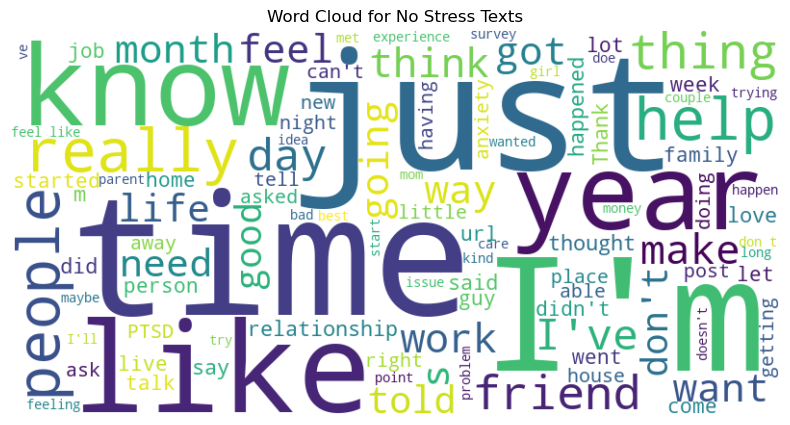

In [9]:
# 4. Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette="Set2")
plt.title("Class Distribution (Stress vs No Stress)")
plt.xlabel("Label (0: No Stress, 1: Stress)")
plt.ylabel("Count")
plt.savefig("class_distribution.png")
plt.show()

# 5. Probability visualization for sample inputs
sample_inputs = [
    "I am happy",
    "My day is full of happiness and joy",
    "I feel sad",
    "I am relaxed",
    "I was beaten by an unknown person",
    "I was beaten by someone",
    "I was beaten and abused by someone",
]
probas = [
    model_text_only.predict_proba(
        tfidf.transform([text.translate(str.maketrans("", "", string.punctuation)).lower()])
    )[0]
    for text in sample_inputs
]
no_stress_probas = [p[0] for p in probas]
stress_probas = [p[1] for p in probas]
print("\nSample Input Probabilities:")
for text, no_stress, stress in zip(sample_inputs, no_stress_probas, stress_probas):
    print(f"{text}: No Stress: {no_stress:.4f}, Stress: {stress:.4f}")

plt.figure(figsize=(8, 6))
bar_width = 0.35
index = np.arange(len(sample_inputs))
plt.bar(index, no_stress_probas, bar_width, label="No Stress", color="#4CAF50")
plt.bar(index + bar_width, stress_probas, bar_width, label="Stress", color="#F44336")
plt.xlabel("Input Text")
plt.ylabel("Probability")
plt.title("Model Probability Outputs for Sample Inputs")
plt.xticks(index + bar_width / 2, sample_inputs, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("sample_probabilities.png")
plt.show()

# 6. Word Cloud for Stress and No Stress Texts
print("Generating word clouds...")
# Stress texts (label=1)
stress_texts = " ".join(data[data["label"] == 1]["text"].astype(str))
wordcloud_stress = WordCloud(
    width=800, height=400, background_color="white", stopwords=ENGLISH_STOP_WORDS, max_words=100
).generate(stress_texts)
plt.figure(figsize=(6, 5))
plt.imshow(wordcloud_stress, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Stress Texts")
plt.savefig("stress_wordcloud.png")
plt.show()

# No Stress texts (label=0)
no_stress_texts = " ".join(data[data["label"] == 0]["text"].astype(str))
wordcloud_no_stress = WordCloud(
    width=800, height=400, background_color="white", stopwords=ENGLISH_STOP_WORDS, max_words=100
).generate(no_stress_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_stress, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for No Stress Texts")
plt.savefig("no_stress_wordcloud.png")
plt.show()

In [10]:
# GUI for user input (using TF-IDF-only model with SVM)
def predict_stress():
    user_text = text_entry.get("1.0", tk.END).strip()
    if not user_text:
        messagebox.showerror("Error", "Please enter some text.")
        return

    try:
        # Clean the text: remove punctuation and apply lowercase
        user_text_cleaned = user_text.translate(str.maketrans("", "", string.punctuation)).lower()
        user_text_tfidf = tfidf.transform([user_text_cleaned])

        # Predict with a balanced custom threshold
        proba = model_text_only.predict_proba(user_text_tfidf)[0]
        prediction = 1 if proba[1] > 0.4 else np.argmax(proba)
        result = "Stress" if prediction == 1 else "No Stress"
        confidence = proba[prediction]

        # Update the result label with the prediction
        result_label.config(
            text=f"Prediction: {result}\nConfidence: {confidence:.4f}",
            fg="#D32F2F" if prediction == 1 else "#388E3C",
        )
        return user_text, result, confidence  # Return for export
    except Exception as e:
        messagebox.showerror("Error", f"Prediction failed: {str(e)}")
        return None, None, None

def export_prediction():
    user_text, result, confidence = predict_stress()
    if user_text is None or result is None:
        messagebox.showerror("Error", "No valid prediction to export.")
        return

    # Export to CSV
    try:
        pd.DataFrame({
            "Text": [user_text],
            "Prediction": [result],
            "Confidence": [confidence]
        }).to_csv("predictions.csv", mode="a", index=False, header=not pd.io.common.file_exists("predictions.csv"))
        messagebox.showinfo("Success", "Prediction exported to predictions.csv")
    except Exception as e:
        messagebox.showerror("Error", f"Failed to export prediction: {str(e)}")

def clear_text():
    text_entry.delete("1.0", tk.END)
    result_label.config(text="Prediction: None\nConfidence: N/A", fg="#333333")

def on_enter(event, button, original_bg, hover_bg):
    button.config(bg=hover_bg)

def on_leave(event, button, original_bg, hover_bg):
    button.config(bg=original_bg)

def update_gradient(canvas, width, height):
    canvas.delete("gradient")
    for i in range(height):
        component = max(0, 255 - i // 2)
        color = f"#{component:02x}{component:02x}FF"
        canvas.create_line(0, i, width, i, fill=color, tags="gradient")

def on_resize(event):
    canvas.configure(width=event.width, height=event.height)
    update_gradient(canvas, event.width, event.height)
    canvas.coords(frame_window, event.width // 2, event.height // 2)

def animate_title():
    current_fg = title_label.cget("fg")
    title_label.config(fg="#42A5F5" if current_fg == "#1976D2" else "#1976D2")
    root.after(1000, animate_title)

In [ ]:
# Enable Tkinter event loop in Jupyter
%gui tk

# Tkinter GUI setup
print("Launching GUI...")
root = tk.Tk()
root.title("Stress Prediction App")
root.geometry("900x900")
root.resizable(True, True)

canvas = tk.Canvas(root, highlightthickness=0)
canvas.pack(fill="both", expand=True)
update_gradient(canvas, 900, 900)
canvas.bind("<Configure>", on_resize)

# Define fonts
title_font = ("Helvetica", 16, "bold")
text_font = ("Helvetica", 12)
button_font = ("Helvetica", 12, "bold")
metric_font = ("Helvetica", 11)

# Create a frame
frame = tk.Frame(root, bg="#FFFFFF", bd=2, relief="flat")

# Title label (fixed syntax error by removing extra parenthesis)
title_label = tk.Label(frame, text="Stress Prediction App", font=title_font, bg='#FFFFFF', fg="#1976D2")
title_label.pack(pady=(20, 10))

# Instruction label
instruction_label = tk.Label(frame, text="Enter your text below to predict stress:", font=("Helvetica", 12), bg="#FFFFFF", fg="#333333")
instruction_label.pack(pady=(10, 5))

# Text entry with scrollbar
text_frame = tk.Frame(frame, bg="#FFFFFF")
text_entry = tk.Text(
    text_frame, height=8, width=50, font=text_font, bg="#F5F5F5", fg="#333333", borderwidth=2, relief="flat", wrap="word"
)
scrollbar = tk.Scrollbar(text_frame, orient="vertical", command=text_entry.yview)
text_entry.config(yscrollcommand=scrollbar.set)
text_entry.pack(side="left", fill="both", expand=True)
scrollbar.pack(side="right", fill="y")
text_frame.pack(pady=10)

# Buttons
button_frame = tk.Frame(frame, bg="#FFFFFF")
predict_button = tk.Button(
    button_frame,
    text="Predict Stress",
    font=button_font,
    command=predict_stress,
    bg="#1976D2",
    fg="white",
    activebackground="#1565C0",
    borderwidth=0,
    relief="flat",
    padx=15,
    pady=5,
)
predict_button.pack(side="left", padx=10)
predict_button.bind("<Enter>", lambda e: on_enter(e, predict_button, "#1976D2", "#1565C0"))
predict_button.bind("<Leave>", lambda e: on_leave(e, predict_button, "#1976D2", "#1565C0"))

clear_button = tk.Button(
    button_frame,
    text="Clear Text",
    font=button_font,
    command=clear_text,
    bg="#E57373",
    fg="white",
    activebackground="#EF5350",
    borderwidth=0,
    relief="flat",
    padx=15,
    pady=5,
)
clear_button.pack(side="left", padx=10)
clear_button.bind("<Enter>", lambda e: on_enter(e, clear_button, "#E57373", "#EF5350"))
clear_button.bind("<Leave>", lambda e: on_leave(e, clear_button, "#E57373", "#EF5350"))

export_button = tk.Button(
    button_frame,
    text="Export Prediction",
    font=button_font,
    command=export_prediction,
    bg="#FFA000",
    fg="white",
    activebackground="#FFB300",
    borderwidth=0,
    relief="flat",
    padx=15,
    pady=5,
)
export_button.pack(side="left", padx=10)
export_button.bind("<Enter>", lambda e: on_enter(e, export_button, "#FFA000", "#FFB300"))
export_button.bind("<Leave>", lambda e: on_leave(e, export_button, "#FFA000", "#FFB300"))

button_frame.pack(pady=10)

# Result label
result_label = tk.Label(
    frame, text="Prediction: None\nConfidence: N/A", font=("Helvetica", 12, "bold"), bg="#FFFFFF", fg="#333333"
)
result_label.pack(pady=(20, 10))

# Model performance metrics
metrics_frame = tk.Frame(frame, bg="#FFFFFF")
main_model_label = tk.Label(
    metrics_frame,
    text=f"Main Model (MultinomialNB)\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}",
    font=metric_font,
    bg="#FFFFFF",
    fg="#1976D2",
    justify="left",
)
main_model_label.pack(pady=(5, 5))
tfidf_model_label = tk.Label(
    metrics_frame,
    text=f"TF-IDF-only Model (SVM)\nAccuracy: {accuracy_text:.4f}\nPrecision: {precision_text:.4f}",
    font=metric_font,
    bg="#FFFFFF",
    fg="#1976D2",
    justify="left",
)
tfidf_model_label.pack(pady=(5, 5))
lr_model_label = tk.Label(
    metrics_frame,
    text=f"LogisticRegression Model\nAccuracy: {accuracy_lr:.4f}\nPrecision: {precision_lr:.4f}",
    font=metric_font,
    bg="#FFFFFF",
    fg="#1976D2",
    justify="left",
)
lr_model_label.pack(pady=(5, 5))
metrics_frame.pack(pady=(10, 20))

# Add frame to canvas
frame_window = canvas.create_window(450, 450, window=frame)

# Title animation
animate_title()

# Run the Tkinter event loop
root.mainloop()

Launching GUI...
